# Single Side Band ptychography example

This example uses an implementation of the single side band method
https://doi.org/10.1016/j.ultramic.2014.09.013 to reconstruct an amplitude and phase
image from a simulated 4D scanning transmission electron microscopy dataset with an additional synthetic
potential modulation.

The dataset can be downloaded at https://zenodo.org/record/5113235.

In [1]:
import os

import matplotlib.pyplot as plt
import libertem.api as lt
import numpy as np
from matplotlib import colors

# note: visulization requires empyre
# install empyre: pip install empyre
from empyre.vis.colors import ColormapCubehelix

from libertem import masks
from libertem.udf.sum import SumUDF
from libertem.common.container import MaskContainer
from libertem.common.backend import set_use_cuda, set_use_cpu, get_device_class
from libertem.corrections.coordinates import identity
from libertem.viz.mpl import MPLLive2DPlot

In [2]:
from ptychography40.reconstruction.ssb import SSB_UDF, generate_masks, BinnedSSB_UDF, crop_bin_params
from ptychography40.reconstruction.common import wavelength, get_shifted

In [3]:
%matplotlib nbagg

## Create the LiberTEM context

An inline executor executes LiberTEM UDFs in the process where this script is running instead of running it on worker processes. This is currently more efficient for this SSB implementation since it allows to re-use precalculated data better. For most other applications, running on distributed workers is faster. See also https://github.com/LiberTEM/LiberTEM/issues/335

In [4]:
# Requires LiberTEM 0.9
# SSB runs particularly well on the threaded executor since
# this allows sharing the masks between threads
ctx = lt.Context.make_with('threads')

## Open the input data

This creates a LiberTEM dataset. The data is not loaded yet, but only when analyses are run on it.

In [5]:
file_params = {'path': r'/cachedata/weber/ssb/slice_00001_thick_1.9525_nm_blocksz100.raw',
          'dtype': 'float32', 'nav_shape': [100, 100], 'sig_shape': [596, 596]}
ds = ctx.load("RAW", **file_params)


## Reconstruction parameters

These have to be adapted for each dataset.

In [6]:
rec_params = {
    # NumPy base dtype for the calculation. Set to numpy.float64 for higher precision
    'dtype': np.float32,
    # Wavelength of the illuminating radiation in m
    'lamb': wavelength(300),
    # Scan step in x and y direction in m
    'dpix': 1.9525e-9/100,
    # Semiconvergence angle of the illumination in radians
    'semiconv': 23e-3/2,
    # Diameter of the zero order disk on the detector in pixels
    'semiconv_pix': 68,
    # Affine transformation matrix for adjusting rotation and handedness between scan and detector coordinates.
    # The scale is handled by the other parameters.
    'transformation': identity(),
    # Position of the direct beam on the detecot in px
    'cy': 297,
    'cx': 297,
    # Minimum size of a trotter. Increase this to suppress noise from very small trotters.
    'cutoff': 1
}
mask_params = {
    # Shape of the reconstructed area
    'reconstruct_shape': tuple(ds.shape.nav),
    # Shape of a detector frame
    'mask_shape': tuple(ds.shape.sig),
    # Use the faster shifting method to generate trotters
    'method': 'shift',
}

## Initial analysis of the dataset

We sum up all frames and confirm that size and position of the zero order beam match.

<IPython.core.display.Javascript object>


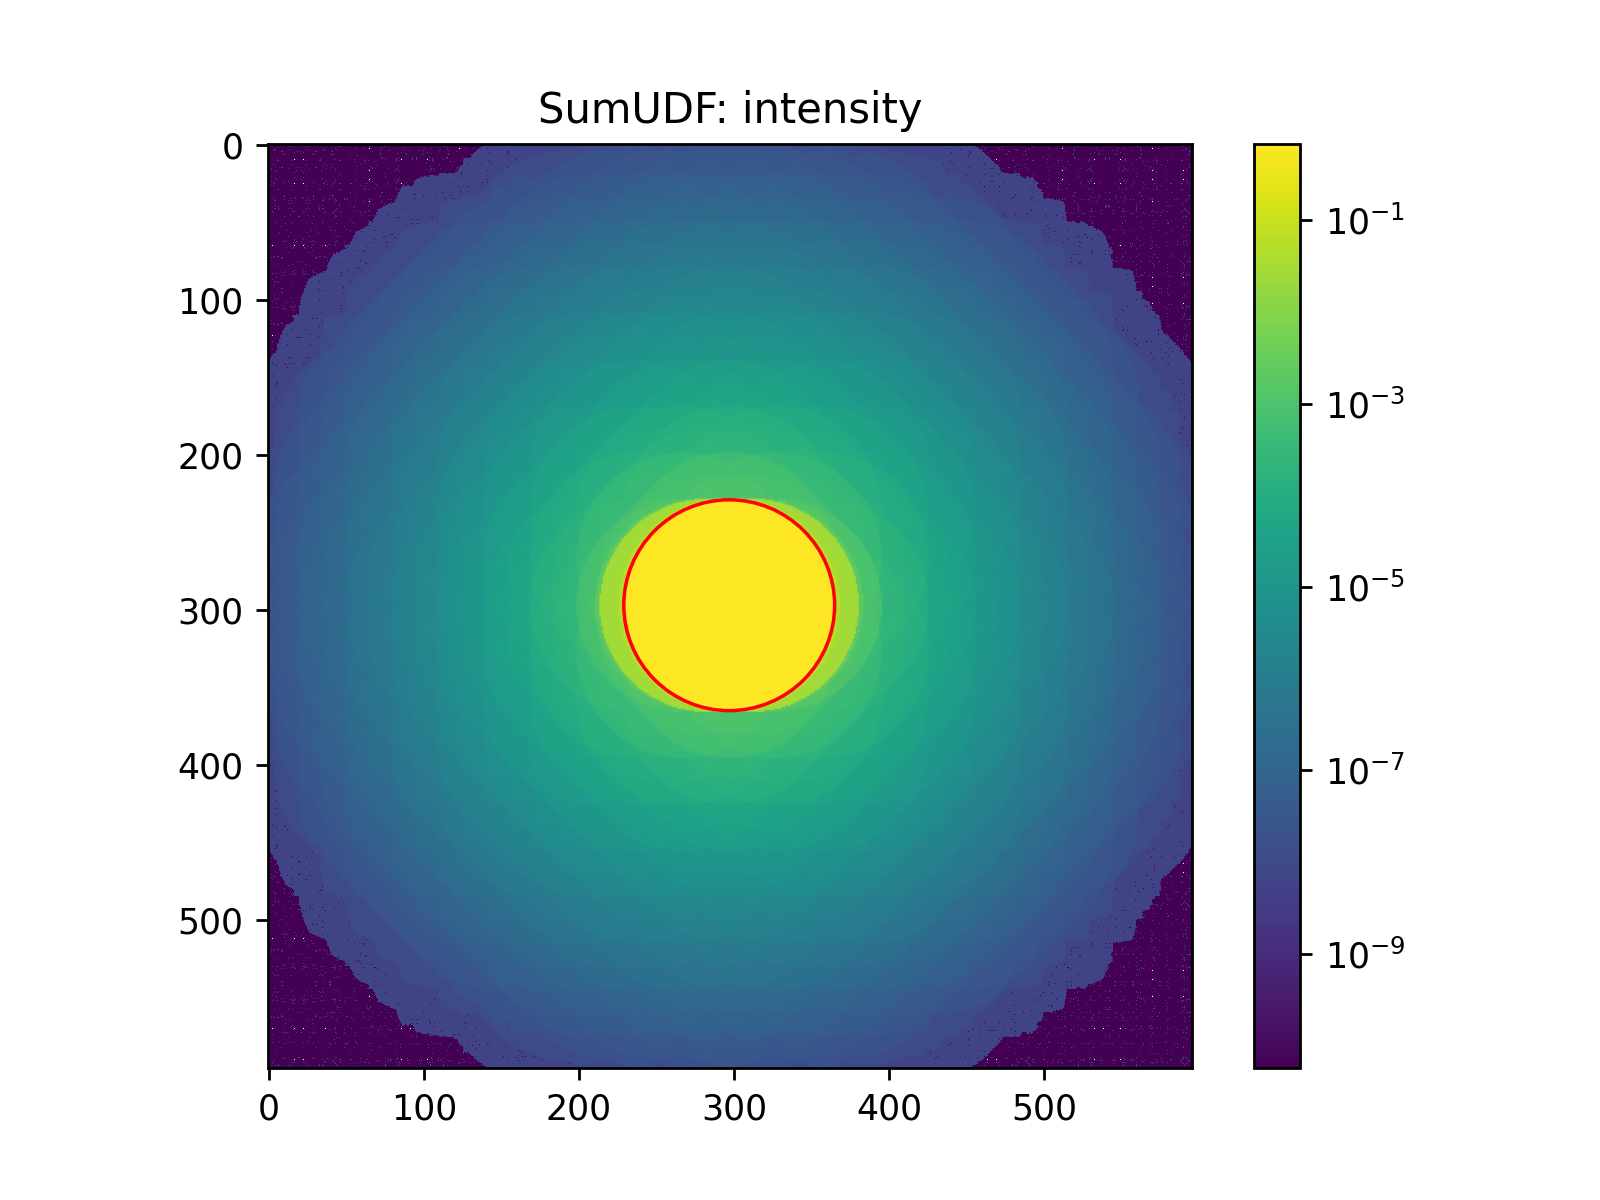

100%|██████████| 27/27 [00:00<00:00, 41.64it/s]


In [7]:
sum_udf = SumUDF()

live_plot = MPLLive2DPlot(
    dataset=ds,
    udf=sum_udf,
    norm=colors.LogNorm()
)
live_plot.display()
circ_a = plt.Circle((rec_params["cx"], rec_params["cy"]), rec_params["semiconv_pix"], fill=False, color='red')
live_plot.axes.add_artist(circ_a)
live_plot.fig.colorbar(live_plot.im_obj)

sum_result = ctx.run_udf(dataset=ds, udf=sum_udf, plots=[live_plot], progress=True)

## Center of mass analysis

This is used to confirm that the coordinate system between scan and detector is properly adjusted. The beam should be deflected towards the nuclei for high resolution STEM data. That means that the field should have little curl and negative divergence at the position of the nuclei. Furthermore, x and y deflection should point towards the nuclei. See also https://libertem.github.io/LiberTEM/concepts.html#coordinate-system

In [8]:
com_analysis = ctx.create_com_analysis(
    dataset=ds,
    cx=rec_params["cx"],
    cy=rec_params["cy"],
    mask_radius=rec_params["semiconv_pix"] + 30
)
com_result = ctx.run(com_analysis, progress=True)
print(com_result)

100%|██████████| 27/27 [00:00<00:00, 55.39it/s]

[<AnalysisResult: field>, <AnalysisResult: magnitude>, <AnalysisResult: divergence>, <AnalysisResult: curl>, <AnalysisResult: x>, <AnalysisResult: y>]


<IPython.core.display.Javascript object>


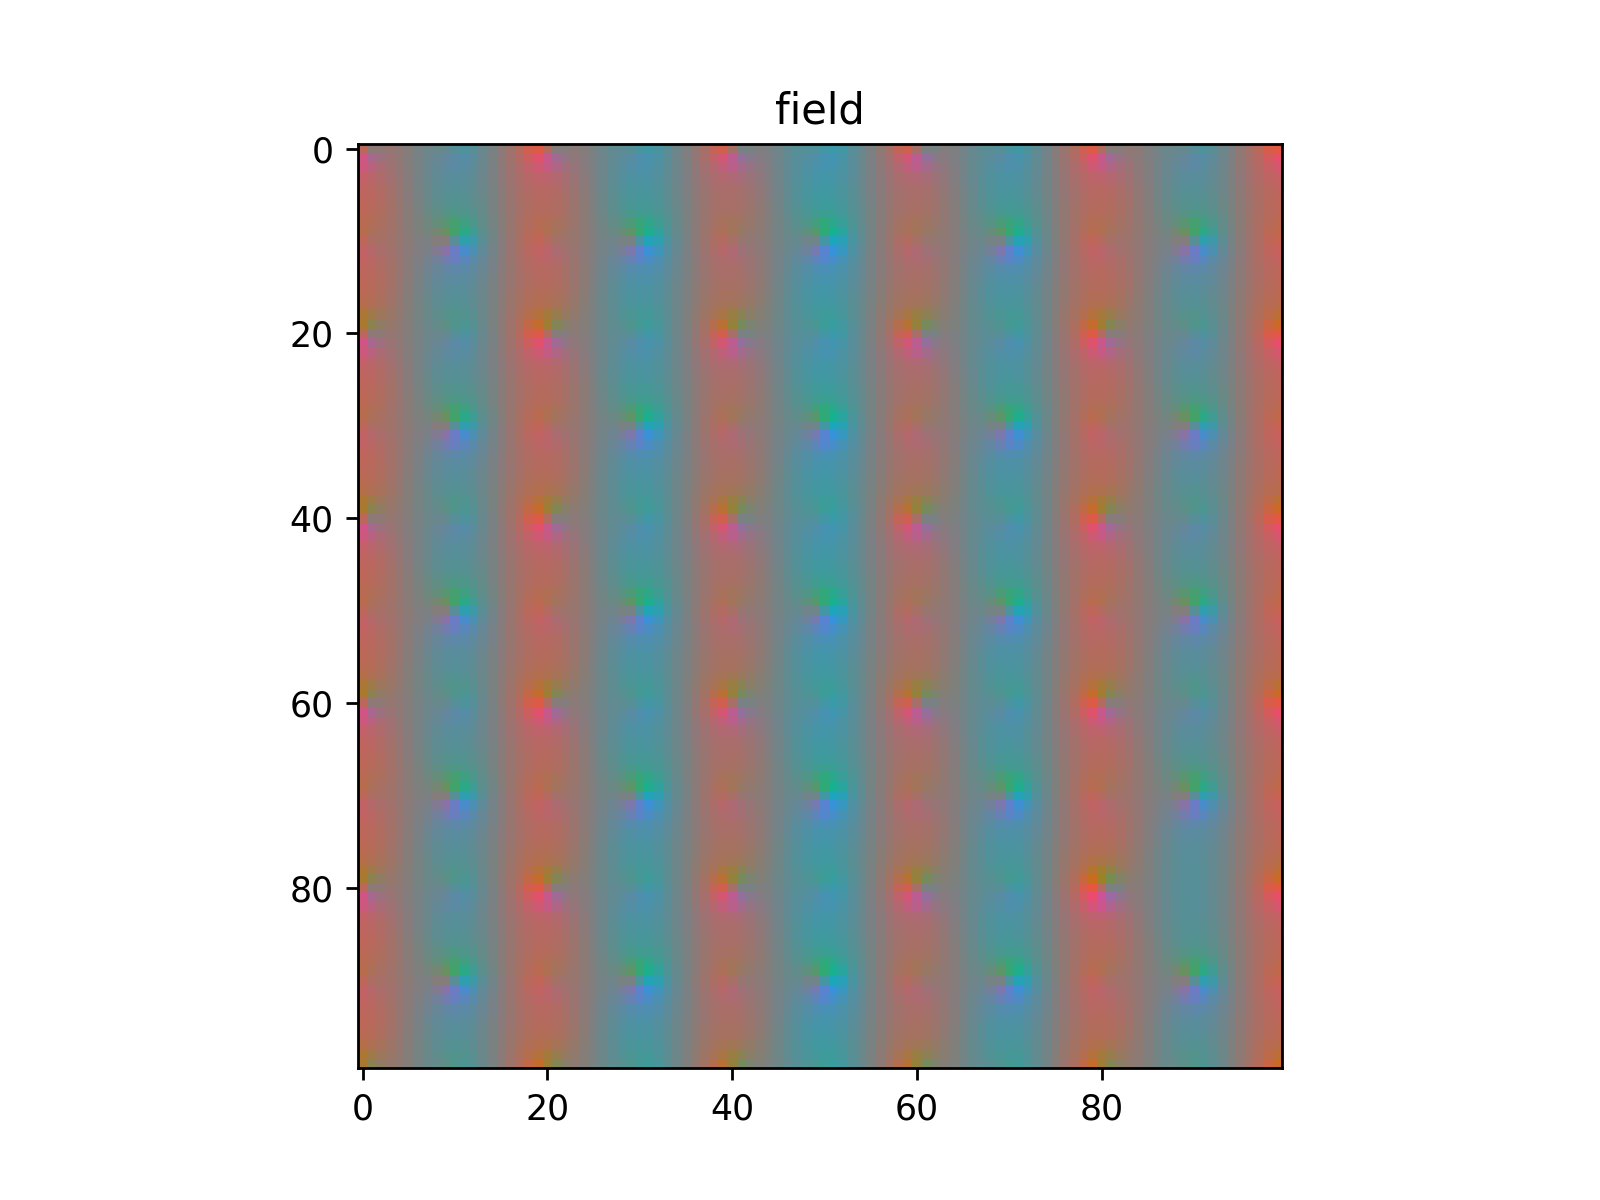

<IPython.core.display.Javascript object>


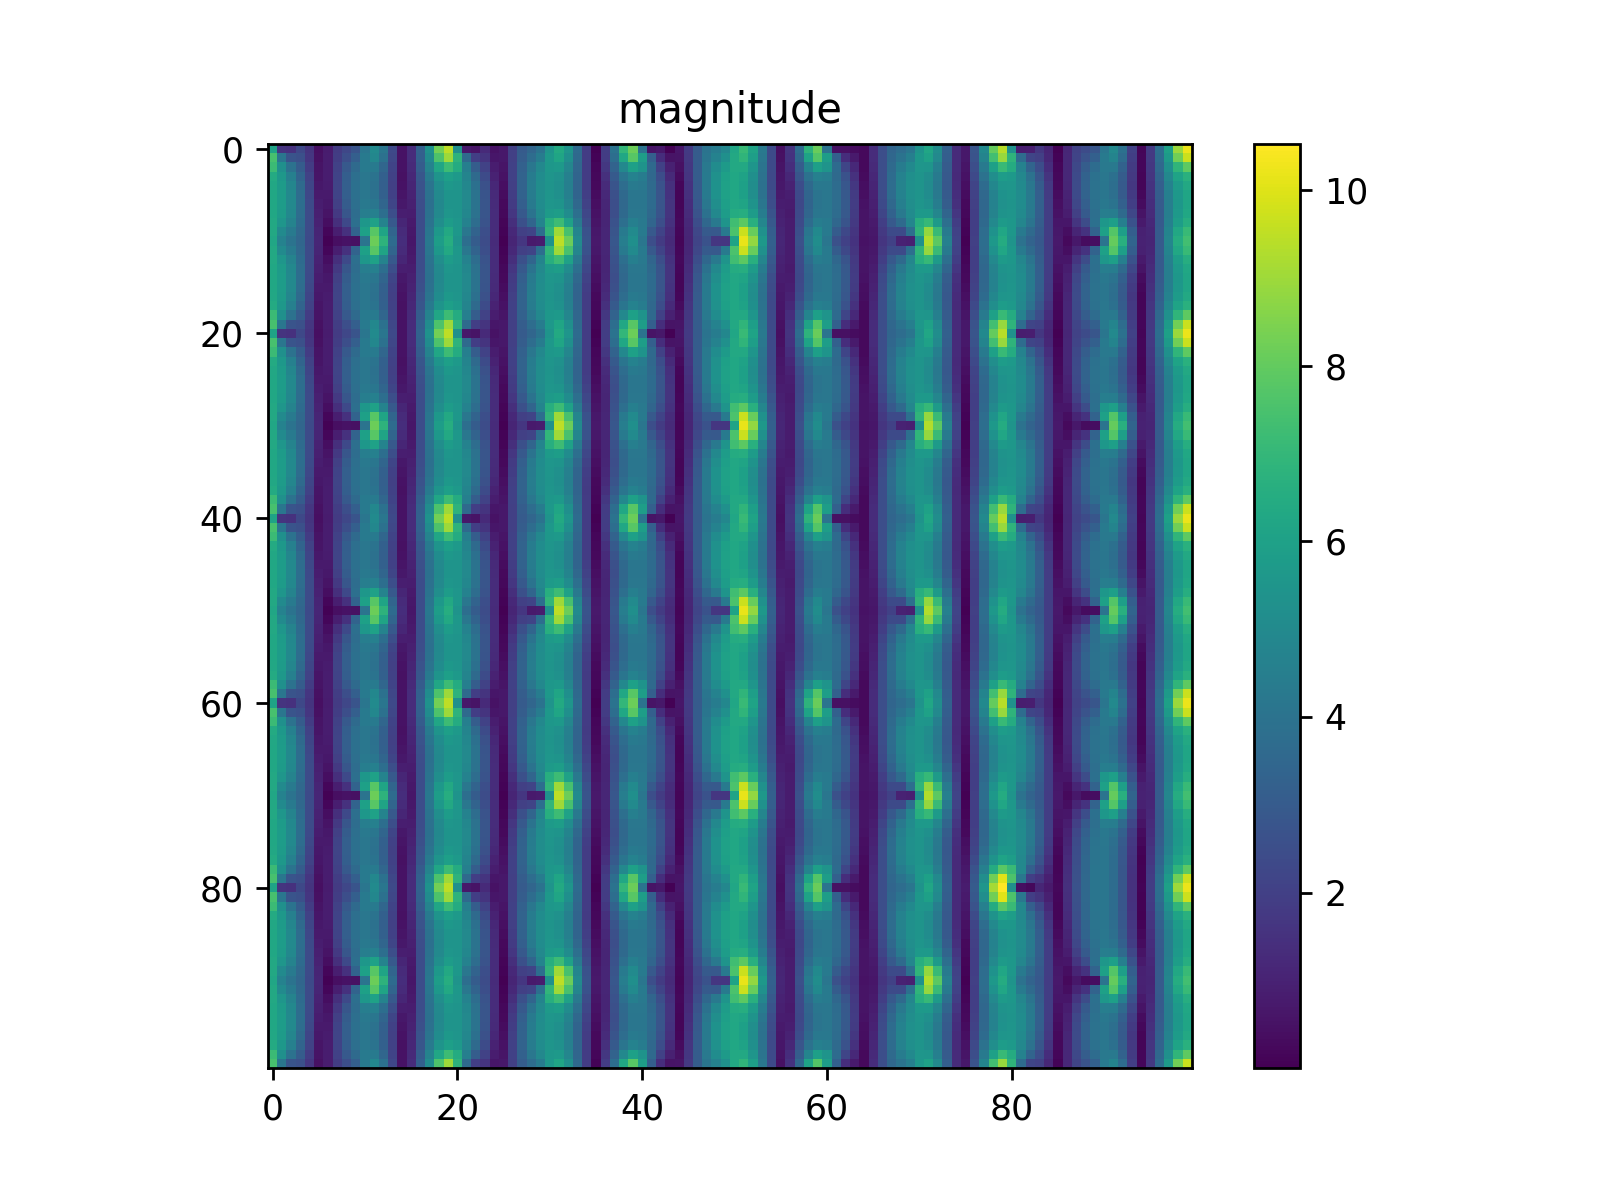

<IPython.core.display.Javascript object>


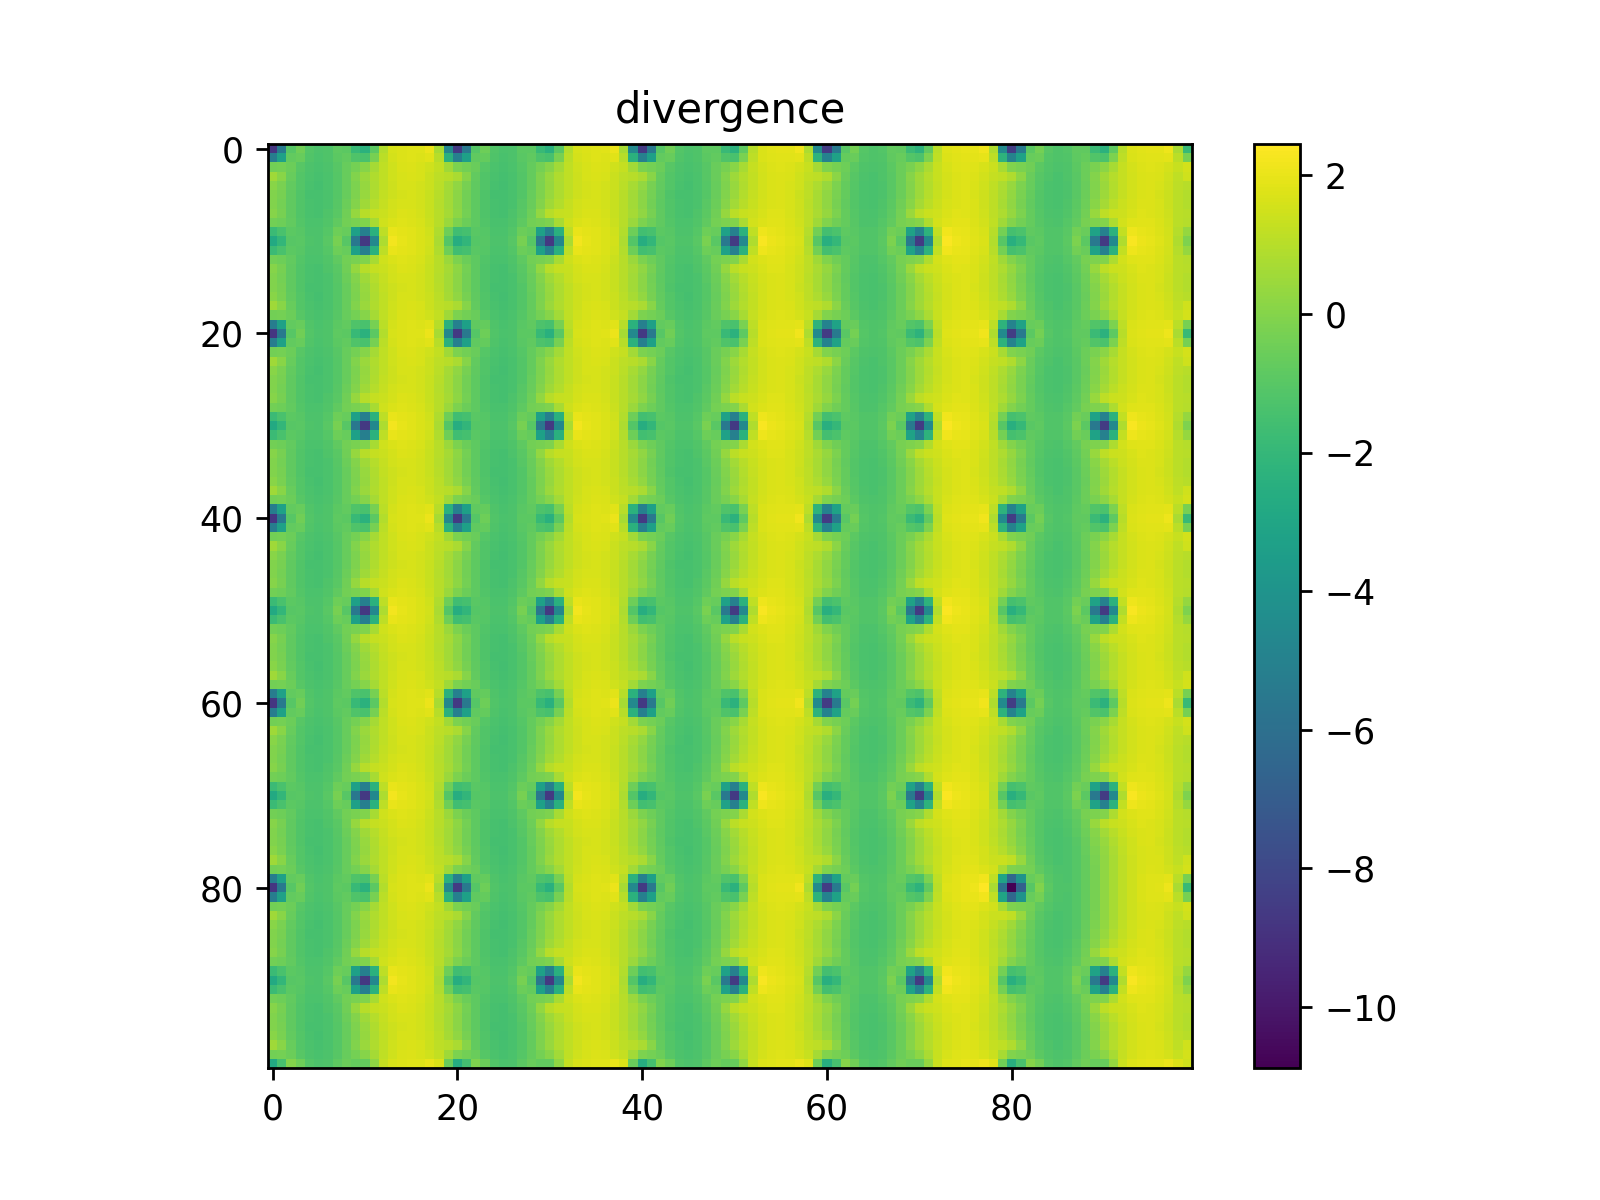

<IPython.core.display.Javascript object>


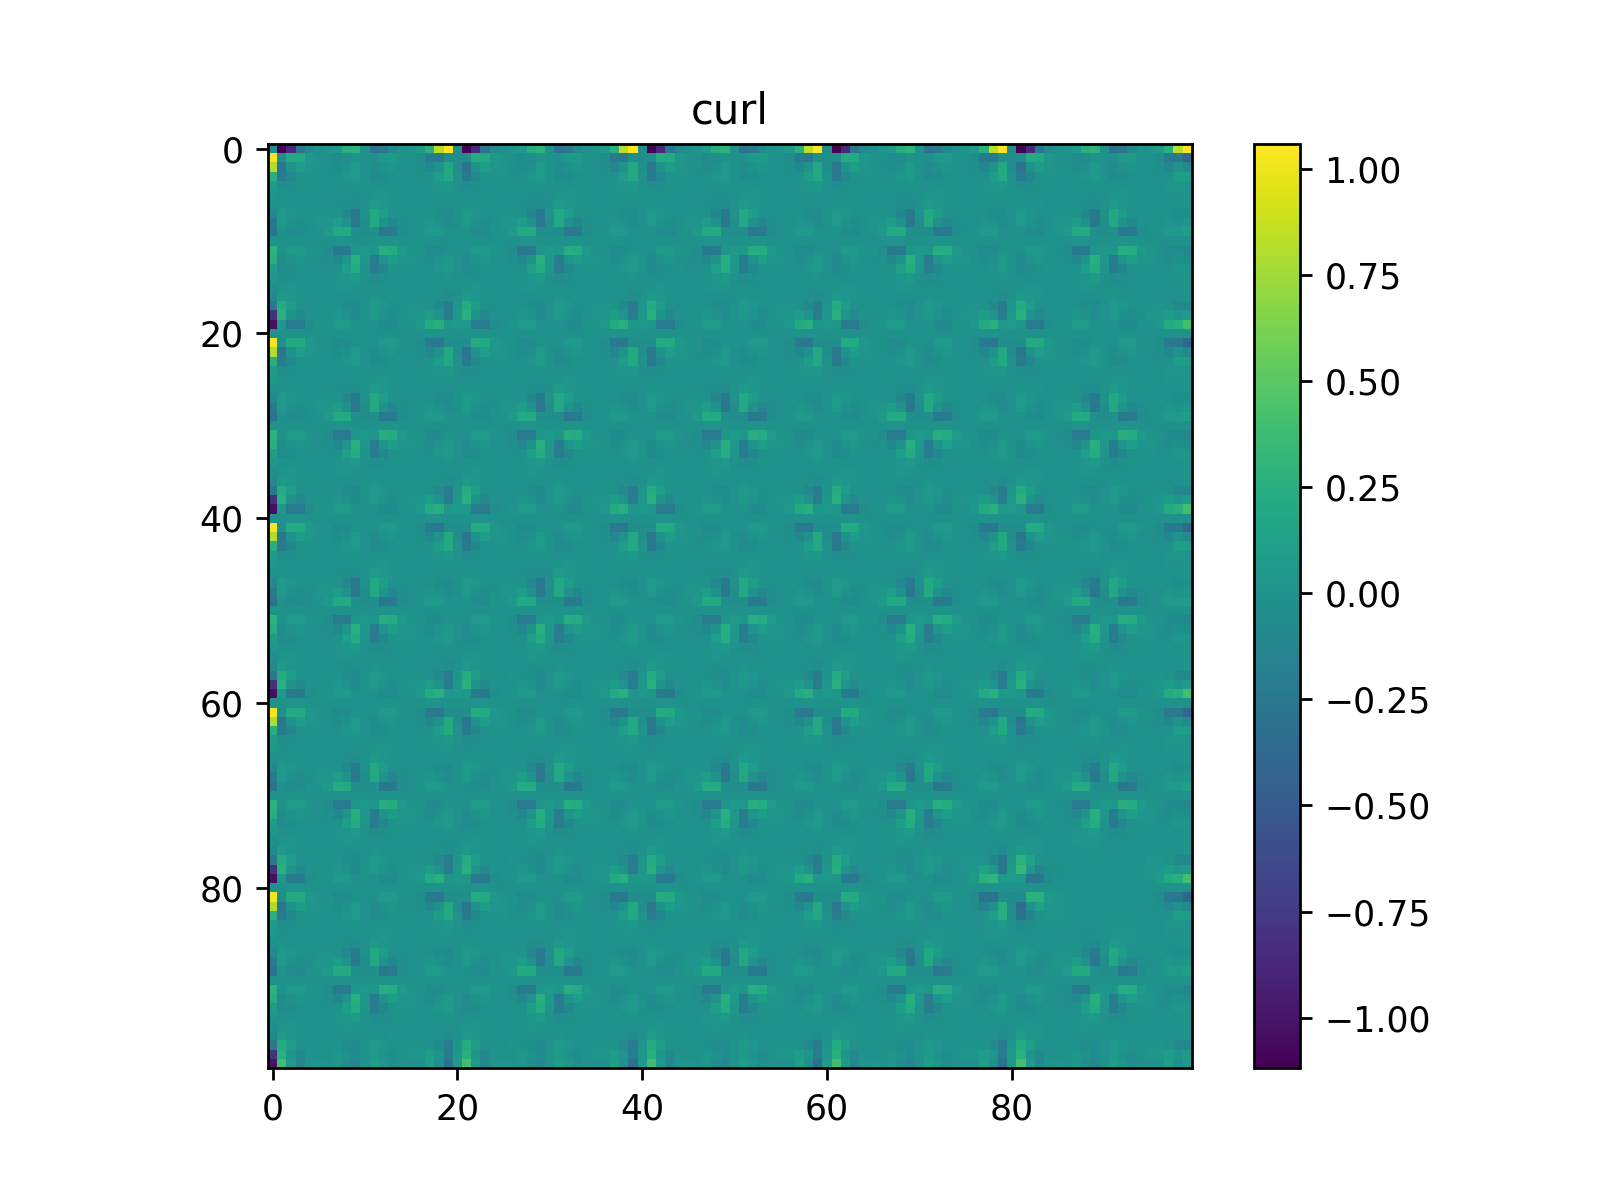

<IPython.core.display.Javascript object>


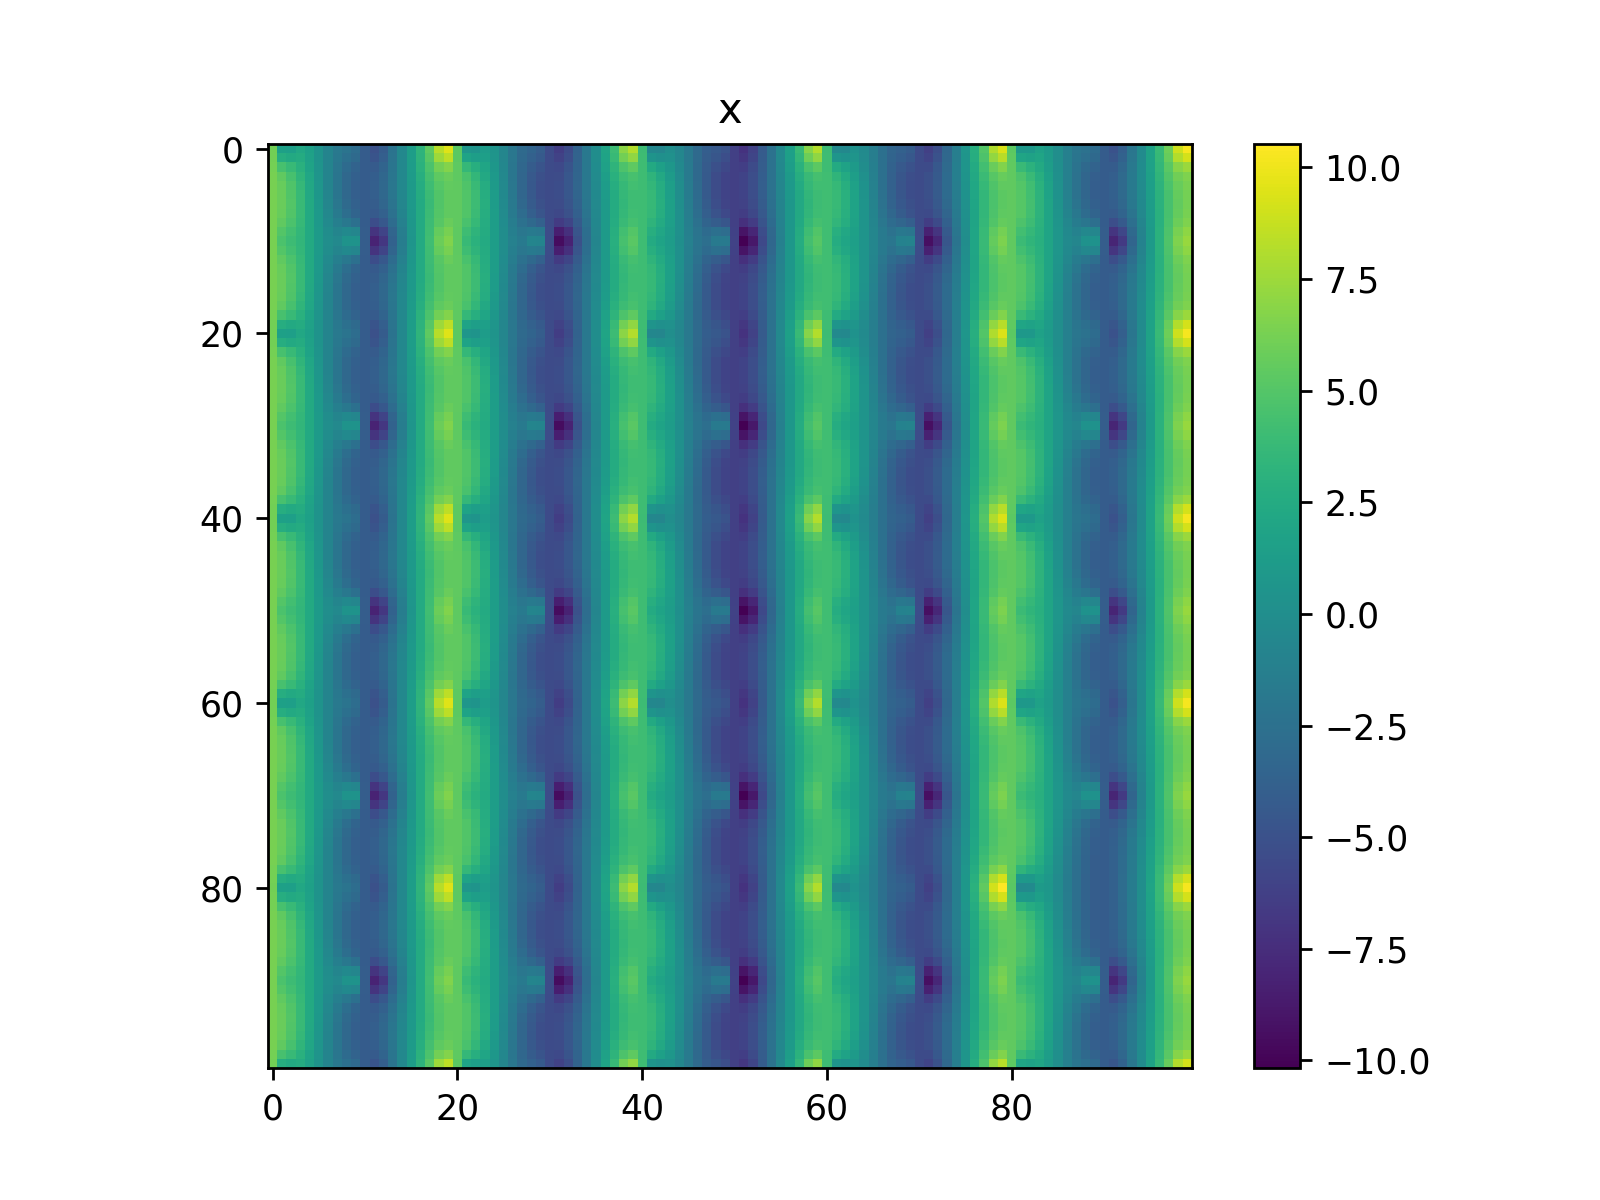

<IPython.core.display.Javascript object>


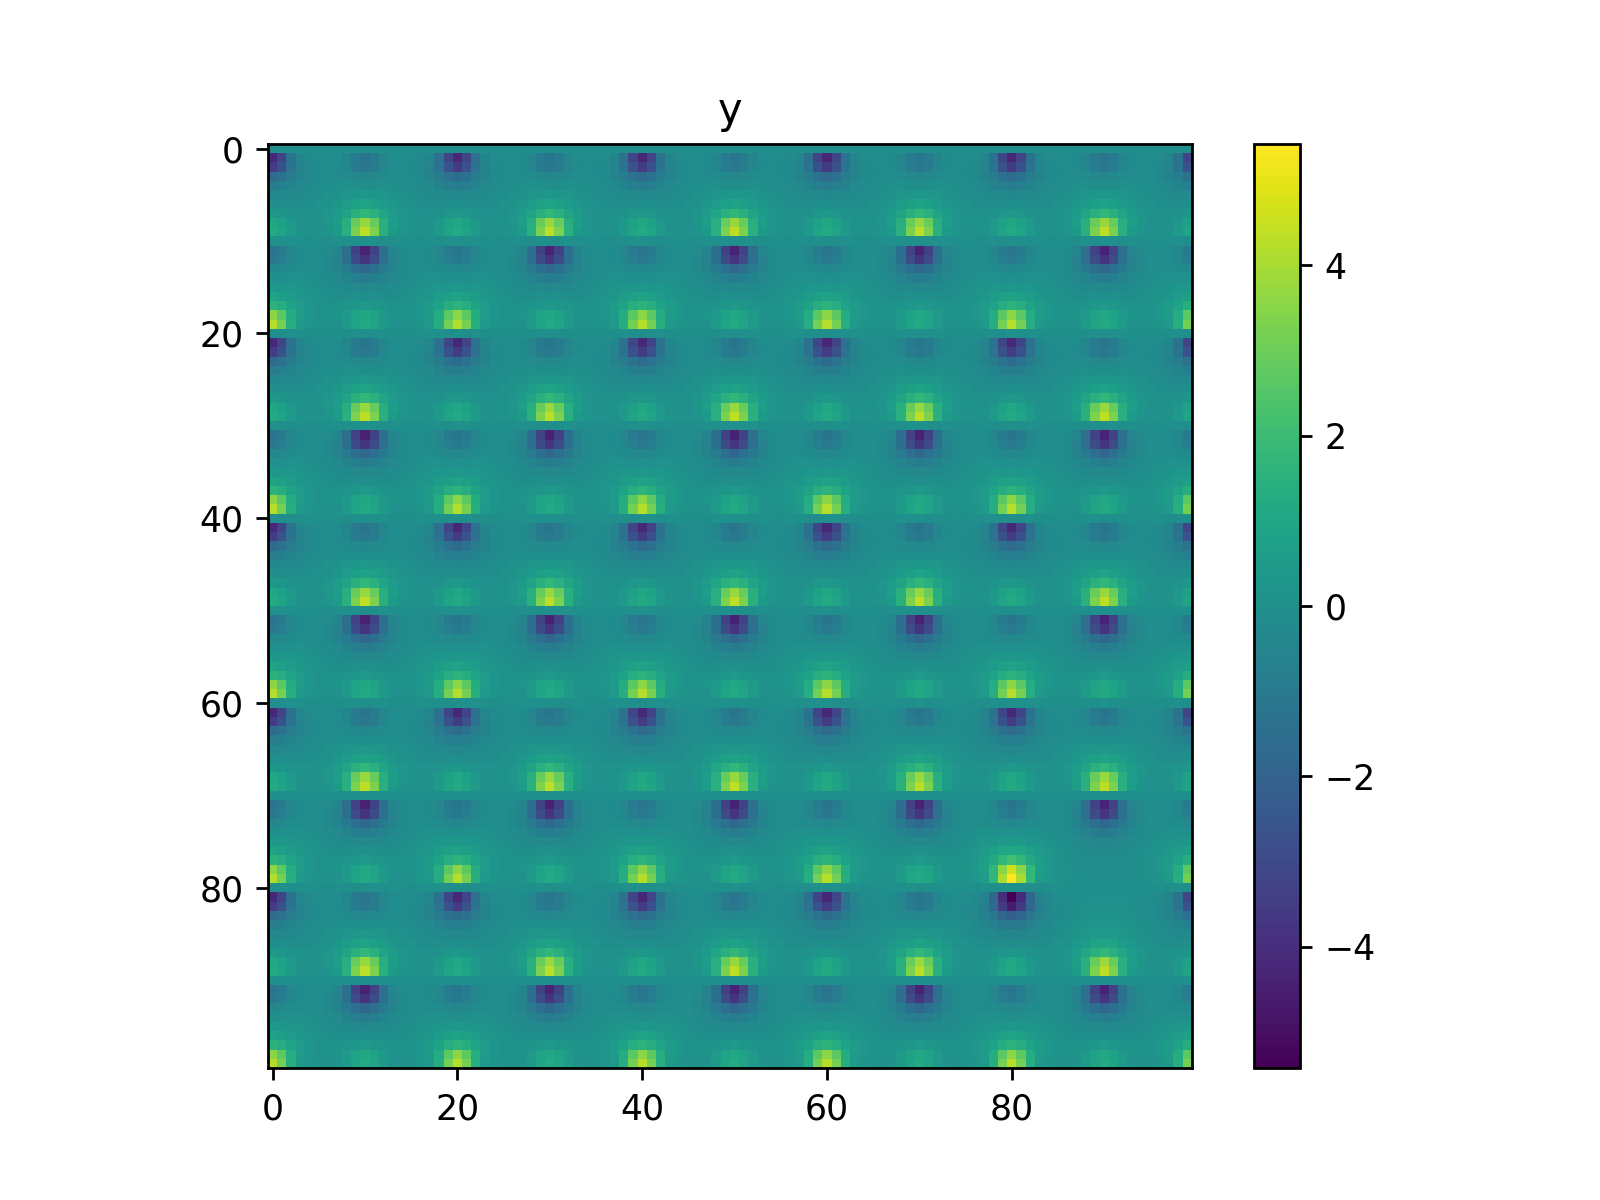

In [9]:
fig, axes = plt.subplots()
axes.set_title("field")
y_centers, x_centers = com_result.field.raw_data
ch = ColormapCubehelix(start=1, rot=1, minLight=0.5, maxLight=0.5, sat=2)
axes.imshow(ch.rgb_from_vector(np.broadcast_arrays(y_centers, x_centers, 0)))

fig, axes = plt.subplots()
axes.set_title("magnitude")
p = axes.imshow(com_result.magnitude.raw_data)
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("divergence")
p = axes.imshow(com_result.divergence.raw_data)
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("curl")
p = axes.imshow(com_result.curl.raw_data)
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("x")
p = axes.imshow(com_result.x.raw_data)
fig.colorbar(p)

fig, axes = plt.subplots()
axes.set_title("y")
p = axes.imshow(com_result.y.raw_data)
fig.colorbar(p)

## Pre-calculate the trotter stack

This takes some time and can be re-used for given reconstruction parameters. The stack is in a sparse matrix format.

In [10]:
%%time
trotters = generate_masks(**rec_params, **mask_params)

CPU times: user 5.88 s, sys: 40.4 ms, total: 5.92 s
Wall time: 5.92 s


<IPython.core.display.Javascript object>


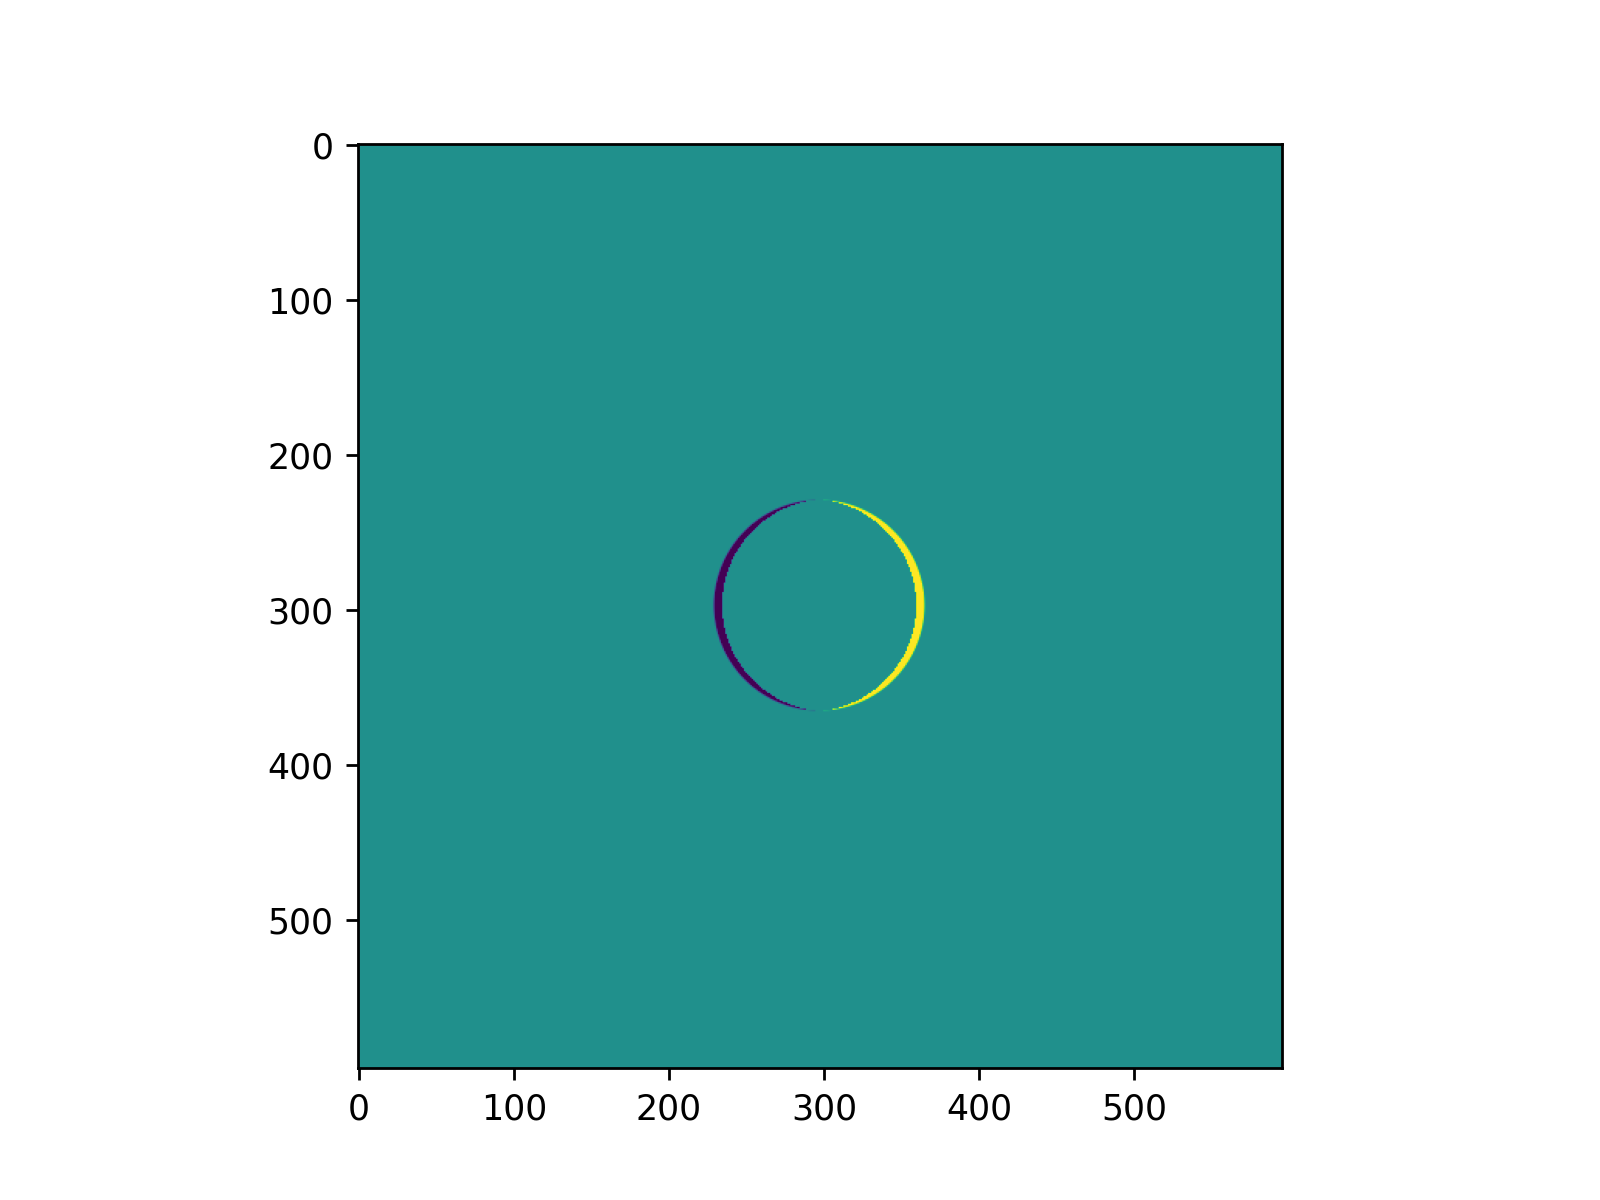

In [11]:
fig, axes = plt.subplots()
axes.imshow(trotters[1].todense())

Uncomment to use GPU processing on device 0 with the inline executor

In [12]:
# set_use_cuda(0)

We create a LiberTEM `MaskContainer` from the mask stack. The `MaskContainer` is used to calculate and cache subsets of the mask stack with optimized properties for a fast dot product and tiled processing.

In [13]:
mask_container = MaskContainer(
    mask_factories=lambda: trotters, dtype=trotters.dtype, count=trotters.shape[0]
)

Mask factory size 132952065 larger than warning limit 1048576, may be inefficient


## Instantiate and run the SSB UDF
The mask_container is passed to the UDF to allow re-use. This is a work-around for https://github.com/LiberTEM/LiberTEM/issues/335

In [14]:
udf = SSB_UDF(**rec_params, mask_container=mask_container)

We create dedicated plots so that we can add a colorbar and only plot amplitude and phase. These plots will be updated with calculation results when running the UDF in the cell after.

<IPython.core.display.Javascript object>


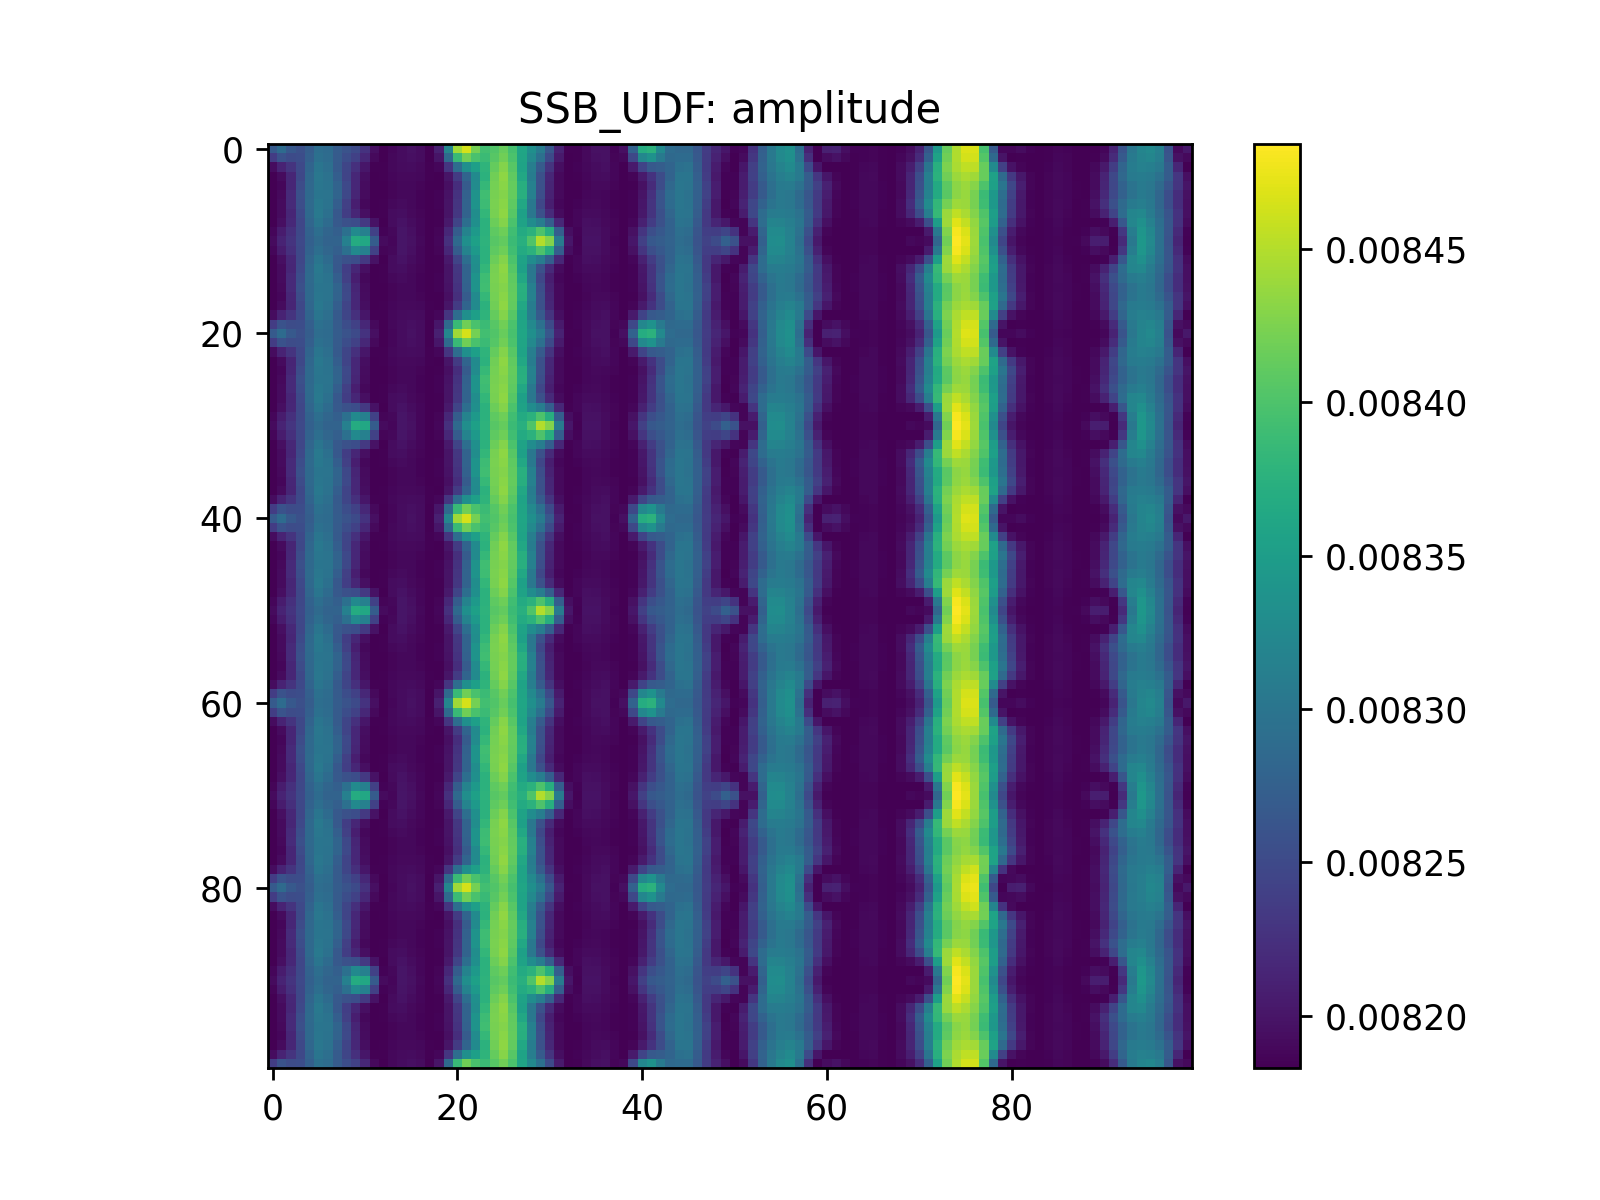

<IPython.core.display.Javascript object>


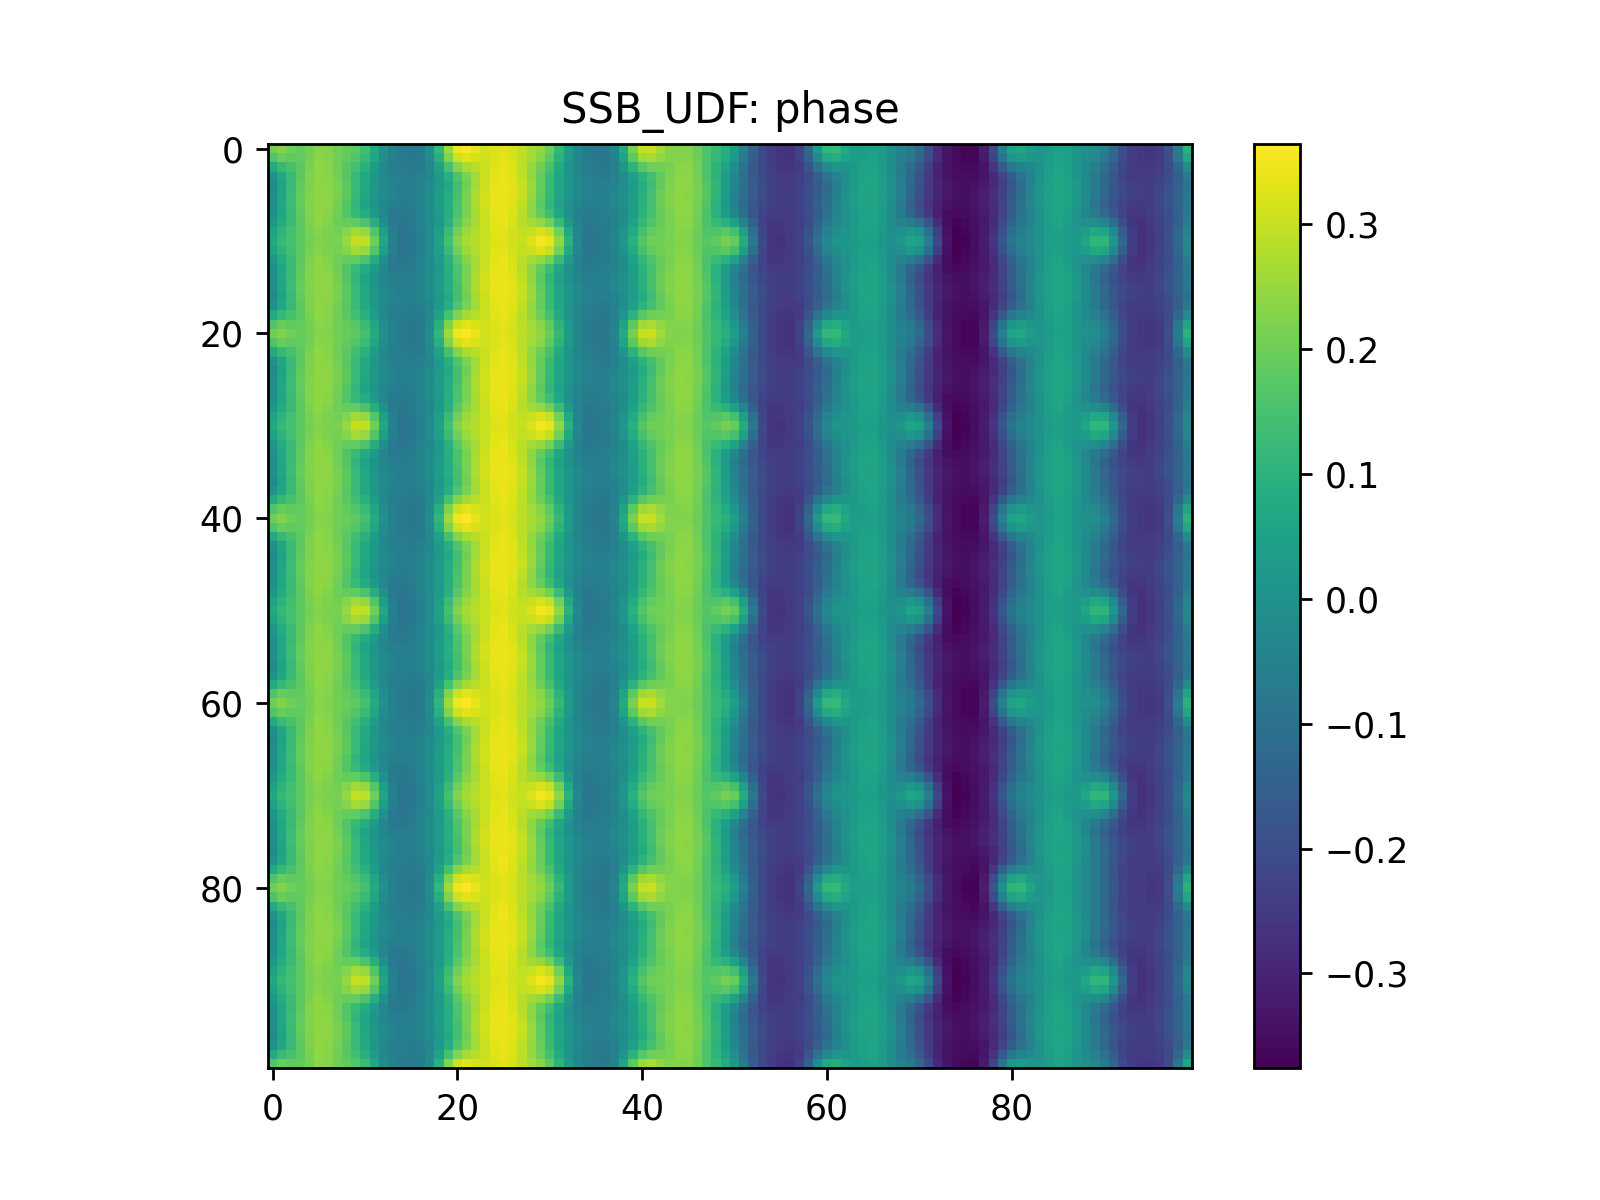

In [15]:
ssb_plots = []
for channel in 'amplitude', 'phase':
    p = MPLLive2DPlot(
        dataset=ds,
        udf=udf,
        channel=channel,
    )
    p.display()
    p.fig.colorbar(p.im_obj)
    ssb_plots.append(p)

In [16]:
%%time
# We use the threaded executor since the sparse matrix stack is quite large.
# Instead of process-based parallelism, we use multithreading.
# This allows to re-use the masks and the cache of MaskContainer between partitions.
udf_result = ctx.run_udf(udf=udf, dataset=ds, plots=ssb_plots, progress=True)

100%|██████████| 27/27 [00:02<00:00, 10.05it/s]


CPU times: user 39.7 s, sys: 6.39 s, total: 46.1 s
Wall time: 2.94 s


## Alternatively, use binned SSB

This crops and bins the data using `BinnedSSB_UDF`. This can be somewhat less precise, but a lot faster than unbinned SSB. The helper function `crop_bin_params()` helps to determine the correct parameters.

In [17]:
binned_rec_params, binned_mask_params, y_binner, x_binner = crop_bin_params(rec_params, mask_params, 8)

In [18]:
%%time
binned_masks = generate_masks(**binned_rec_params, **binned_mask_params)

CPU times: user 526 ms, sys: 3.26 ms, total: 530 ms
Wall time: 529 ms


In [19]:
binned_mask_flat = binned_masks.reshape((
    binned_masks.shape[0], binned_masks.shape[1]*binned_masks.shape[2]
))
csr_trotters = binned_mask_flat.tocsr()
binned_udf = BinnedSSB_UDF(
    y_binner=y_binner,
    x_binner=x_binner,
    csr_trotters=csr_trotters,
)

In [20]:
%%time
binned_result = ctx.run_udf(dataset=ds, udf=binned_udf, progress=True)

100%|██████████| 27/27 [00:00<00:00, 50.52it/s]

CPU times: user 6.22 s, sys: 636 ms, total: 6.85 s
Wall time: 540 ms


<IPython.core.display.Javascript object>


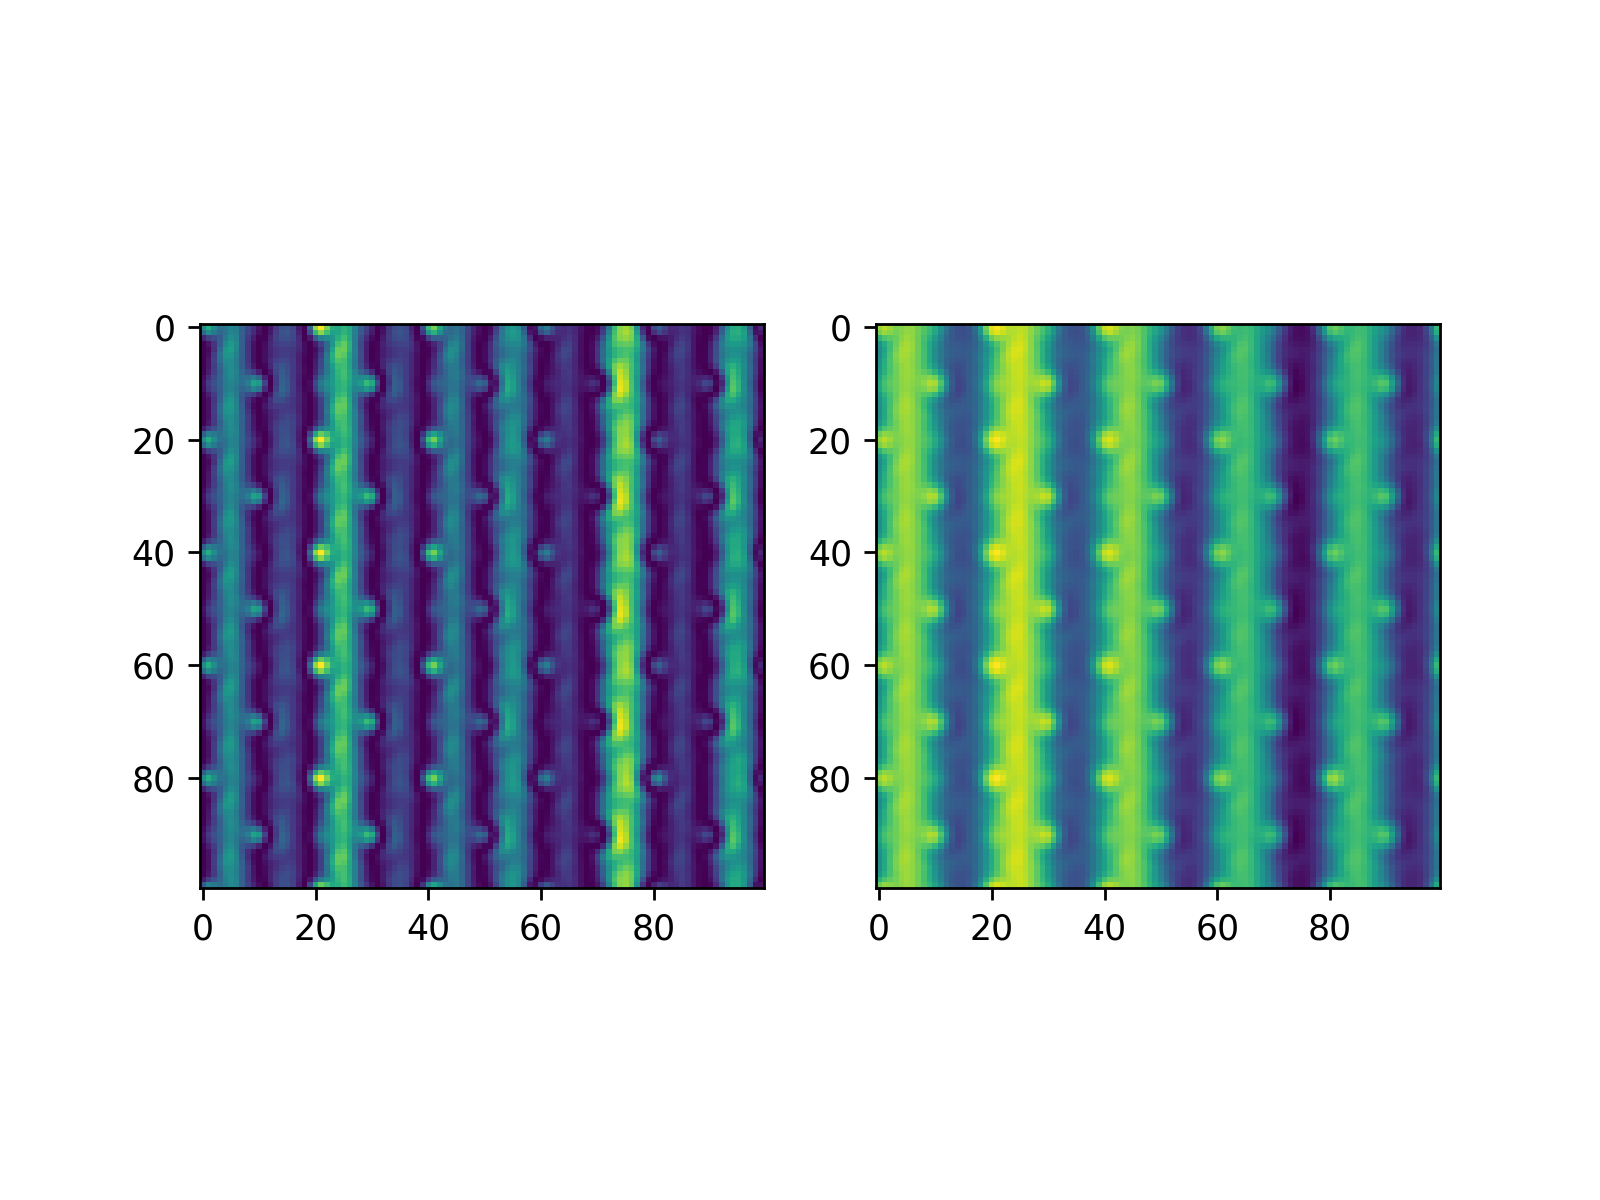

In [21]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(binned_result['amplitude'])
axes[1].imshow(binned_result['phase'])